# Wisdom Tree Assignment

We start by importing the libraries that we will need later on

In [1]:
import numpy as np
import pandas as pd
import os.path as pth

import matplotlib.pyplot as plt

from time import time
from WT_functions import plot_contract
from WT_functions import IndexConstruction

## Get and Clean Data

As first steps, we:
- Get the dataframes we will need to perform the analysis from the `.csv` files, namely `contracts_prices.csv` and `contracts_info.csv`.
- Transform date columns into `pd.datetime`.
- Sort the DataFrame by index first (trading date), then by maturity year and maturity month.
- Merge the contracts' information DataFrame with `df` in order to compute the metrics that are involving the `contract_size`. 

In [2]:
filename = 'contracts_prices.csv' 
filename_info = 'contracts_info.csv'

filepath = pth.join(pth.join('Other', 'WisdomTree'), filename)  # insert here the right path
filepath_info = pth.join(pth.join('Other', 'WisdomTree'), filename_info)  # insert here the right path

df = pd.read_csv(filepath).set_index('date')
df_info = pd.read_csv(filepath_info).set_index('contract_code')
names_mapping = df_info.contract_short_name.to_dict()

# turn date columns into datetime dtype
df.index = pd.to_datetime(df.index, format='%d/%m/%Y')
df.loc[:, 'last_trade_date'] = pd.to_datetime(df['last_trade_date'], format='%d/%m/%Y')

df = df.reset_index().sort_values(['date', 'mat_year', 'mat_month'], ascending=[True, False, False]).set_index('date')
df = df.merge(df_info, left_on='contract_code', right_index=True)

We define the value of the contract by multiplying the current price by the size of the contract. Then we compute the open interest and the volume in USD and the 1 month (22 business days) moving average of the latter.


In [3]:
df['value_USD'] = df.close.mul(df.contract_size)
df['oi_USD'] = df.oi.mul(df.value_USD).fillna(0)
df['volume_USD'] = df.volume.mul(df.value_USD).fillna(0)

lbls = ['contract_code', 'mat_month', 'mat_year']
volume_ma = df.groupby(lbls)['volume_USD'].rolling(window=22, min_periods=1).mean()
df = df.set_index(lbls, append=True).join(volume_ma, rsuffix='_1M_MA').reset_index().set_index('date')

We wrapped up the previous code in a single function called `get_and_tidy_up_data`

In [2]:
from WT_functions import get_and_tidy_up_data
df, names_mapping = get_and_tidy_up_data(filename='contracts_prices.csv', filename_info='contracts_info.csv')

func:'get_and_tidy_up_data' args:[(), {'filename': 'contracts_prices.csv', 'filename_info': 'contracts_info.csv'}] took: 10.4893 sec


## Some Plots

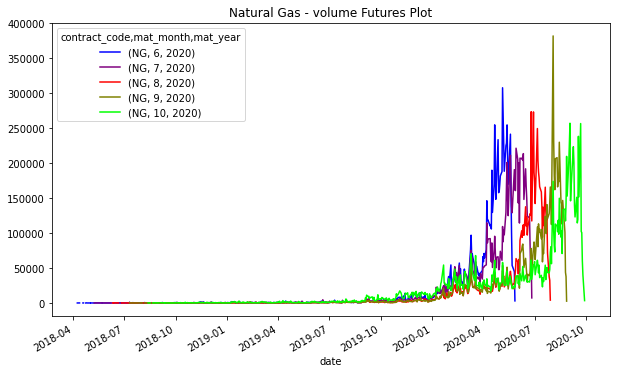

In [4]:
plot_contract('volume', df, 'NG', [6, 7, 8, 9, 10], [2020], names_mapping)

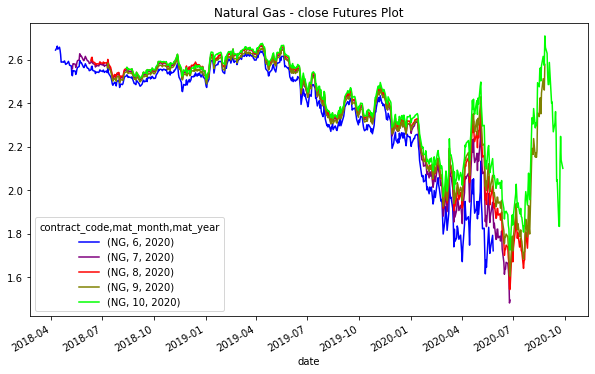

In [5]:
plot_contract('close', df, 'NG', [6, 7, 8, 9, 10], [2020], names_mapping)

## Optimal Future Maturity

For each one of the commodity we have to find the *optimal future maturity* on the last day of each month. In order to to this, we first find the *optimal future maturity contract* for each day and then we will resample the Dataframe obtained in order to sample the right contract at each month end.

With the **implied roll yield** defined as

$$\text{Implied Roll Yield}_i = \bigg( \frac{\text{Price of contract}_{i-1}}{\text{Price of contract}_{i}} - 1 \bigg) \frac{1}{\text{# of months between the contracts}}$$

The **optimal future maturity** is defined, for each date, as the contract $i$ that satisfies:

$$\max_i \bigg( \text{Implied Roll Yield}_i \bigg)$$

Given that the it has an **open interest of at least 100 USD/mln** and **1-month average daily USD volume of at least 30 USD/mln**.